# RNAseq differential expression analysis of TEs in Drosophila melanogaster (DmGoth lineage)

## Alignment to TE Consensus sequences

TE consensus sequences are contained in D_mel_transposon_sequence_set.fa (downloaded from https://github.com/bergmanlab/transposons/ )
By aligning reads to these sequences, we can identify which TEs are expressed and get countings.

Commands : 
```
~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC29.fastq.gz | samtools sort -o FC29.against_consensus.bam

~/softs/minimap2/minimap2 -ax splice ~/cristina_TE/data/consensus/D_mel_transposon_sequence_set.fa ~/cristina_TE/data/reads/FC30.fastq.gz | samtools sort -o FC30.against_consensus.bam
```
We get two bam files as a result (FC29 : 5.2Go, FC30 : 1.8Go )

## Some informations on our reads...

Here's an example of what's in D_mel_transposon_sequence_set.fa : 
```
>1731#LTR/Copia
TGTTGAATATAGGCAATGCCCACATGTGTGTTGAATATAGGCAATTTCCACATGTGCATA
TGTAATTTTGTATGAGAACATACATACATACACATGAACTGTATGTATGTATATATATTA
```

And here's the beginning of the BAM we get by aligning our reads to the TEs consensus sequences : 
```
e1bae963-07b0-44fa-8a67-ae90f86c4ba0    2064    Tc3#DNA/Tc1-Mariner     331     38      710H32M5D19M2D8M1D5M1D18M1D4M1D124M1384H        *       0
       0       GGTTTTACGCTTCTAACTTGACTTCTTGTTTGTTAAATCTCGAAAGTTAAATTCTTTTGATTCTAAATATAAATTATCTTTTTAATTTTTTCTCAAATGGTCCGCGAAAAGTCTTTATCCGATTTTGAAAAAGGTCAAATCAAAGGCTATATTGAATCTGGTTTAAAACACTGTGTAATAGCCAAGAAAATCGGTTGAAGTCAAAACGTT      53/a:/-$7)4/($,%"/$#''-2#"$-5'"''$#'&$%'$"+2%4)*+/)(:?-L/$)2(('#/7+(,$+.#&%(%#&'0-%+(*16995,0.*?;3;9;+*+*/(--)&"%()%8<89210OG?*)NPMPKGC)6>:>*/H5?;-%3/2B4.DLL./A8<:*'A>-"1%#)0255A<*5H2.N(JQ@=J+?@A+-6L7K4)KT1=@WR      NM:i:35 ms:i:115        AS:i:115        nn:i:0  tp:A:P  cm:i:9  s1:i:64 s2:i:0  de:f:0.1389     SA:Z:McClintock#LTR/Gypsy,592,+,1229S153M2I920S,60,11;  rl:i:0
```

We want to count how many reads are aligned on each TEs sequences BUT, we need to remind ourselves that a read can be aligned to several features, then, which one should we count ?

Let's get a look at the alignQC report for FC30.bam
```
alignqc analyze FC30.sorted.bam -g D_mel_transposon_sequence_set.fa -o FC30.consensus.report/FC30.consensus.alignqc.xhtml
```

Well, that didn't work. Seems like a Windows return carriage error ? Maybe this could help :
```
tr -d '\r' < D_mel_transposon_sequence_set.fa > D_mel_transposon_sequence_set.fixed.fa
```
NGS crashed in the meantime, and it did not help : we still got the same error message : 
```
  File "/data/home/ecumunel/.local/lib/python2.7/site-packages/seqtools/errors.py", line 813, in get_context_target_errors
    r[t][tafter]['-']['total'] += 0.5
KeyError: 'Y'
```

Another thing to take into account :
They are primary, secondary, supplementary and unmapped reads. Which one should we count and not count ?
I guess we should discard supplementary alignments and unmapped reads.
Let's check manually how many primary and secondary reads we got.


#### Example case of a supplementary read : e1bae963-07b0-44fa-8a67-ae90f86c4ba0

This read generate two alignments : one primary (in McClintock#LTR/Gypsy) and one supplementary (in Tc3#DNA/Tc1-Mariner). The alignment score is better in the primary. In both case, the alignment covers a very small part of the consensus sequence...



In [2]:
import pysam
import pandas as pd
import re

FC29_bamfile = "data/consensus/bam/FC29.against_consensus.bam"
FC30_bamfile = "data/consensus/bam/FC30.against_consensus.bam"


In [5]:
unmapped = 0
supp = 0
secondary = 0
primary = 0
with pysam.AlignmentFile(FC29_bamfile, 'rb') as bam1:
    for ali in bam1:
        if ali.is_supplementary:
            supp += 1
        elif ali.is_unmapped:
            unmapped += 1
        elif ali.is_secondary:
            secondary += 1
        else:
            primary += 1
print(supp, unmapped, secondary, primary)

424 2918185 953 7369


So we've got around 3 millions unmapped reads, 400 supplementary, 1000 secondary and 7369 primary alignments. This seems very low, but considering we only aligned against TE consensus sequences, which is like 2% of the transcriptome, it's actually not so bad. And FC29 is the smallest dataset.

A more helpful number should be the number of single mapped read (read that mapped to only one feature)  
TODO : fix the following script.

In [9]:
FC29_alignments = pysam.AlignmentFile(FC29_bamfile, 'rb')
read_index = pysam.IndexedReads(FC29_alignments)
read_index.build()



## Getting the expression level of each TE

We can extrapolate the expression level of a said TE from the number of reads that mapped on its consensus sequence.
A table representing the counting of each feature between female and male. A ratio would be preferable as we have fewer reads from female to work with. Only primary read are being counted.

Let's gather our data into a python dict first : 

In [3]:
def get_countings_from_bam(bamfile):
    counting_dict = dict()
    alignment_file = pysam.AlignmentFile(bamfile, 'rb')
    for ali in alignment_file:
        if not ali.is_secondary and not ali.is_supplementary and not ali.is_unmapped :
            if not ali.reference_name in counting_dict :
                counting_dict[ali.reference_name] = 0
            counting_dict[ali.reference_name] += 1
    return counting_dict

consensus_counting_female_dict = get_countings_from_bam(FC29_bamfile)
consensus_counting_male_dict = get_countings_from_bam(FC30_bamfile)

full_consensus_counting_dict = dict()
for feature in consensus_counting_female_dict:
    if not feature in consensus_counting_male_dict :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], 0]
    else :
        full_consensus_counting_dict[feature] = [consensus_counting_female_dict[feature], consensus_counting_male_dict[feature]]

for feature in consensus_counting_male_dict:
    if not feature in consensus_counting_female_dict :
        full_consensus_counting_dict[feature] = [0, consensus_counting_male_dict[feature]]

print(full_consensus_counting_dict)

{'Tc3#DNA/Tc1-Mariner': [4, 0], '1731#LTR/Copia': [39, 0], 'mdg3#LTR/Gypsy': [6, 0], 'mdg1#LTR/Gypsy': [11, 4], 'gypsy#LTR/Gypsy': [23, 1], 'copia#LTR/Copia': [245, 131], 'Bari1#DNA/Tc1-Mariner': [1, 1], 'jockey#LINE/Jockey': [39, 7], '17.6#LTR/Gypsy': [96, 4], 'R1A1-element#LINE/R1': [1, 2], 'Cr1a#LINE/CR1': [34, 6], 'TAHRE#LINE/Jockey': [135, 4], 'gypsy8#LTR/Gypsy': [19, 0], 'gypsy7#LTR/Gypsy': [1, 1], 'G5A#LINE/Jockey': [217, 15], 'invader5#LTR/Gypsy': [1, 1], 'ZAM#LTR/Gypsy': [37, 0], 'FB#DNA/Tc1-Mariner': [19, 15], 'G4#LINE/Jockey': [99, 0], 'invader4#LTR/Gypsy': [8, 1], 'Max-element#LTR/Bel-Pao': [75, 14], '3S18#LTR/Bel-Pao': [32, 0], 'frogger#LTR/Copia': [43, 0], 'Dm88#LTR/Copia': [13, 2], 'GATE#LTR/Bel-Pao': [23, 0], 'Doc#LINE/Jockey': [133, 6], 'gypsy10#LTR/Gypsy': [690, 2], 'invader1#LTR/Gypsy': [92, 4], 'Tom1#LTR/Gypsy': [135, 246], 'HB#DNA/Tc1-Mariner': [64, 3], 'flea#LTR/Gypsy': [50, 7], 'BS3#LINE/Jockey': [29, 0], 'NOF#DNA/MuDR': [4, 0], 'Stalker2#LTR/Gypsy': [8, 29], 'ho

**Let's translate those numbers into ratio, transform this dict into a dataframe and save into a csv file.**

In [21]:
total_count_female = 0
total_count_male = 0
for count_female, count_male in full_consensus_counting_dict.values():
    total_count_female += count_female
    total_count_male += count_male

full_consensus_ratio_dict = dict()
for feature, counting in full_consensus_counting_dict.items():
    female_ratio = 0 if counting[0] == 0 else counting[0]/total_count_female
    male_ratio = 0 if counting[1] == 0 else counting[1]/total_count_male
    full_consensus_ratio_dict[feature] = [female_ratio, male_ratio]

In [44]:
consensus_ratio_df = pd.DataFrame.from_dict(full_consensus_ratio_dict)
consensus_ratio_df = consensus_ratio_df.T
consensus_ratio_df.columns = ["Female", "Male"]
consensus_ratio_df.index.name = "TE"
print(consensus_ratio_df.index.name)

consensus_ratio_df.to_csv("consensus_TE_ratio.csv")
# consensus_ratio_df.head()

TE


#### Let's plot this for readibility

Warning : colors doesn't match between female and male pie chart.

In [47]:
consensus_ratio_df = pd.read_csv("consensus_TE_ratio.csv", index_col="TE")
consensus_ratio_df.head()

,Female,Male
TE,,
Tc3#DNA/Tc1-Mariner,0.000543,0.000000
1731#LTR/Copia,0.005292,0.000000
mdg3#LTR/Gypsy,0.000814,0.000000
mdg1#LTR/Gypsy,0.001493,0.003239
gypsy#LTR/Gypsy,0.003121,0.000810


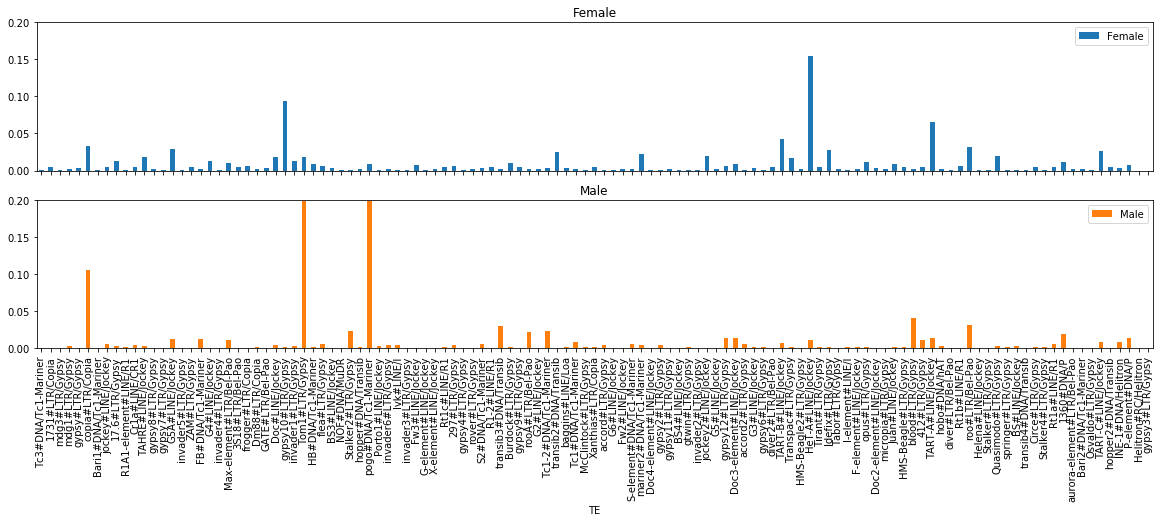

In [62]:
axs = consensus_ratio_df.plot.bar(figsize=(20,6), subplots=True, ylim=(0, 0.2))

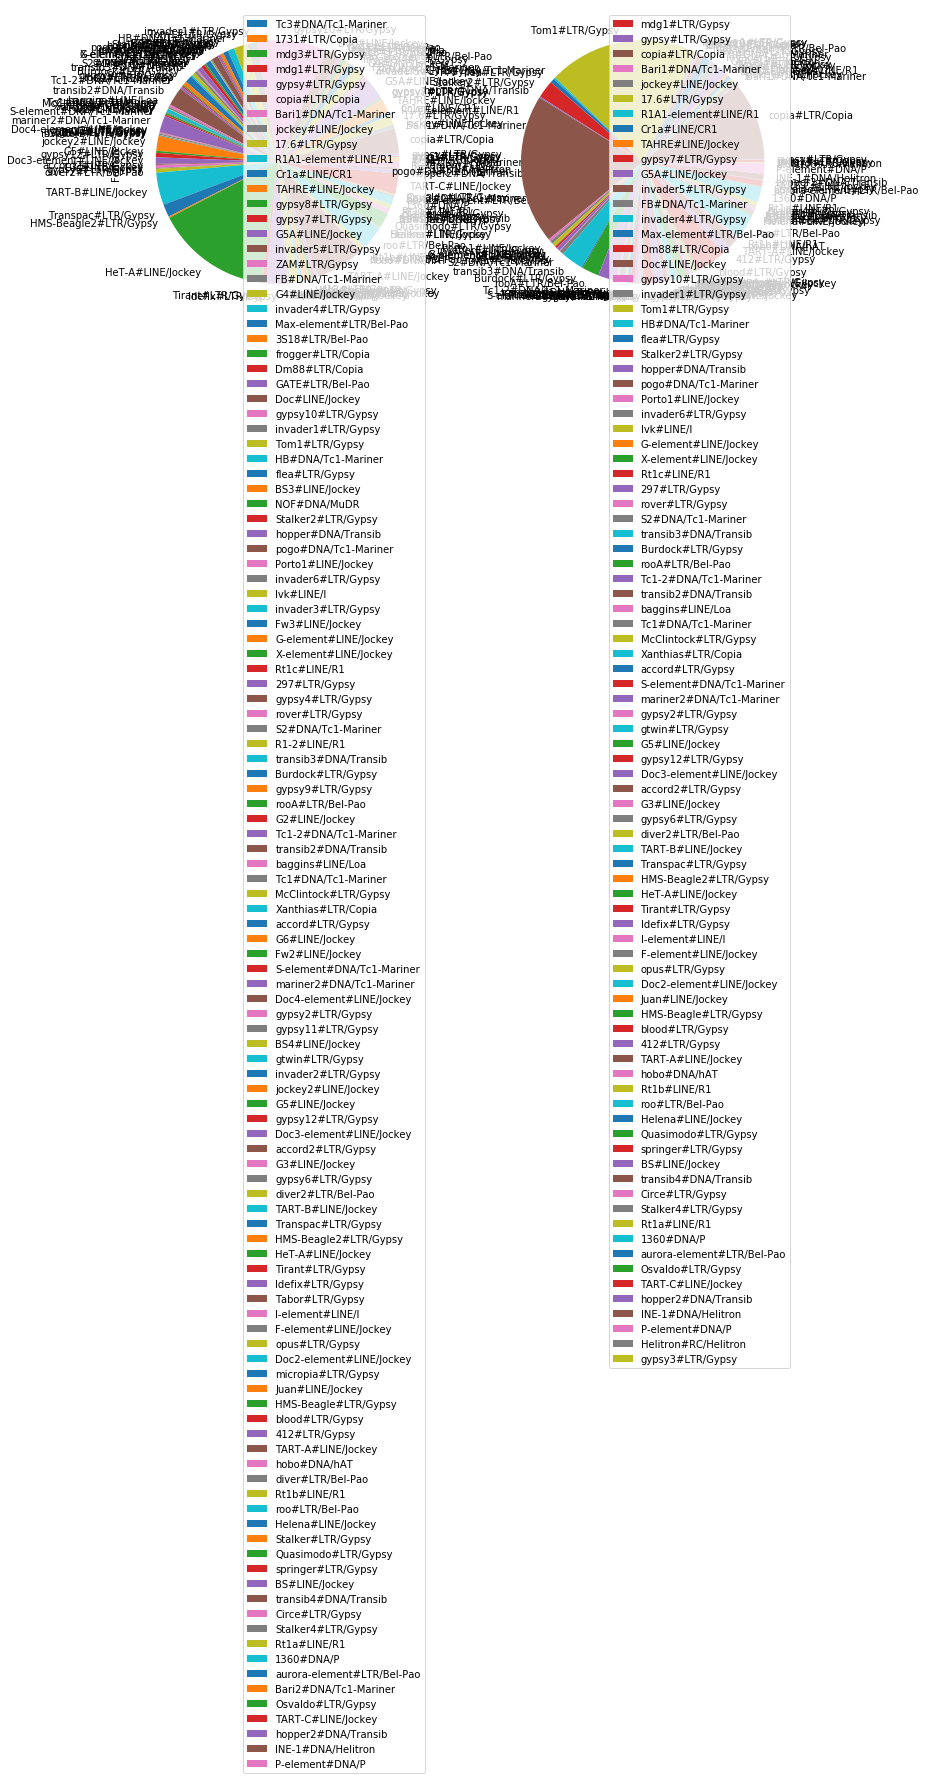

In [70]:
# def get_autopct(pct):
#     return ('%.2f' % pct) if pct > 1 else '' 

axs = consensus_ratio_df.plot.pie(figsize=(12,6), subplots=True)

In [96]:
full_consensus_counting_dict
consensus_TE_counts_df = pd.DataFrame.from_dict(full_consensus_counting_dict).T
consensus_TE_counts_df.columns = ["Female", "Male"]
consensus_TE_counts_df.index.name = "ID"

te_names = []
te_familys = []
te_super_familys = []
for te in consensus_TE_counts_df.index :
    te_name, te_super_family, te_family = re.split('#|/', te)
    te_names.append(te_name)
    te_familys.append(te_family)
    te_super_familys.append(te_super_family)


consensus_TE_counts_df.insert(0, "Dup", te_names)
consensus_TE_counts_df.insert(1, "Family", te_familys)
consensus_TE_counts_df.insert(2, "SuperFamily", te_super_familys)
consensus_TE_counts_df.head()


,Dup,Family,SuperFamily,Female,Male
ID,,,,,
Tc3#DNA/Tc1-Mariner,Tc3,Tc1-Mariner,DNA,4,0
1731#LTR/Copia,1731,Copia,LTR,39,0
mdg3#LTR/Gypsy,mdg3,Gypsy,LTR,6,0
mdg1#LTR/Gypsy,mdg1,Gypsy,LTR,11,4
gypsy#LTR/Gypsy,gypsy,Gypsy,LTR,23,1


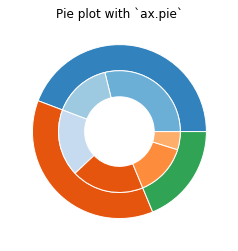

In [172]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap([1,2,3,4,5,6,7,9,10])

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [153]:
print(list(range(len(df["SuperFamily"]))))
print(df["SuperFamily"].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118]
['DNA' 'LTR' 'LINE' 'RC']


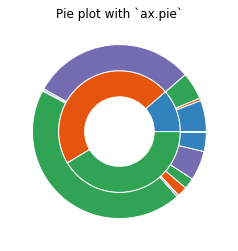

In [227]:
df = consensus_TE_counts_df.copy()
df.sort_values(['SuperFamily', 'Family', 'Dup'], inplace = True)
color_array = []
color_superfamily_dict = {'DNA' : 0, 'LTR' : 9, 'LINE' : 4, 'RC' : 10}
for super_family in df["SuperFamily"]:
    color_array.append(color_superfamily_dict[super_family])

fig, ax = plt.subplots()

size = 0.3
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(df["SuperFamily"].unique()))*4)
inner_colors = cmap(color_array)
# inner_colors = cmap([1, 2, 5, 6, 9, 10])
ax.pie(df.groupby('SuperFamily')['Female'].sum(), radius=1-size, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(df.groupby('Family')['Female'].sum(), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(df["Female"], radius=1, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))
ax.pie(df.groupby('Family')['Female'].sum(), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

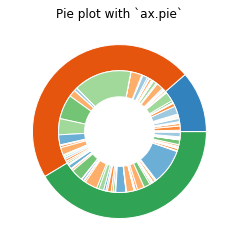

In [213]:

fig, ax = plt.subplots()

size = 0.3
cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(len(df["SuperFamily"].unique()))*4)
inner_colors = cmap(color_array)
inner_colors = cmap([1, 2, 5, 6, 9, 10])
ax.pie(df.groupby('SuperFamily')['Female'].sum(), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(df["Female"], radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))
# ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
#        wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

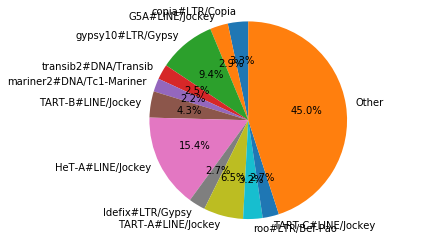

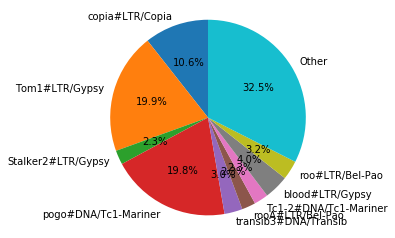

In [7]:
import matplotlib.pyplot as plt

## FEMALE PIE CHART

def get_simple_pie_chart_from_consensus(consensus_counting_dict, min_ratio_threshold = 0.02):
    total_count = sum(consensus_counting_dict.values())
    other_count = 0
    label_list = []
    count_list = []
    for feature, count in consensus_counting_dict.items():
        ratio = 0 if count == 0 else count/total_count
        # ratio = 0 if count == 0 else count/total_count_female
        if ratio >= min_ratio_threshold:
            label_list.append(feature)
            count_list.append(count)
        else:
            other_count += count
    label_list.append('Other')
    count_list.append(other_count)

    fig1, ax1 = plt.subplots()
    ax1.pie(count_list, labels=label_list, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

get_simple_pie_chart_from_consensus(consensus_counting_female_dict)
get_simple_pie_chart_from_consensus(consensus_counting_male_dict)

#### Pie chart by family


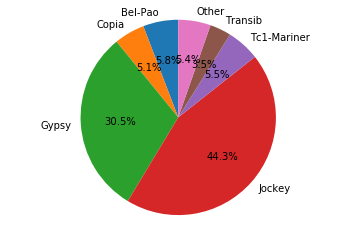

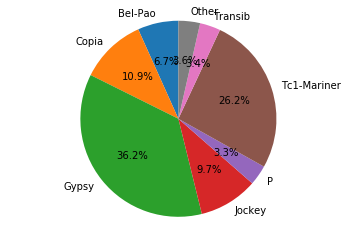

In [62]:
def get_count_per_family(count_dict):
    count_per_family_dict = dict()
    for feature, count in count_dict.items():
        element, rest = feature.split("#")
        superfamily, family = rest.split("/")
        if not family in count_per_family_dict:
            count_per_family_dict[family] = 0
        count_per_family_dict[family] += count

    return count_per_family_dict

def sort_family_dict(family_dict):
    return dict(sorted(family_dict.items(), key=lambda item: item[0]))
    
female_count_per_family_dict = get_count_per_family(consensus_counting_female_dict)
male_count_per_family_dict = get_count_per_family(consensus_counting_male_dict)

female_count_per_family_dict = sort_family_dict(female_count_per_family_dict)
male_count_per_family_dict = sort_family_dict(male_count_per_family_dict)

get_simple_pie_chart_from_consensus(female_count_per_family_dict)
get_simple_pie_chart_from_consensus(male_count_per_family_dict)



#### Some trouble with the query coverage of some TEs...

The query coverage of some TE can be very low, as seen here on IGV for 1731#LTR/Copia :
![title](doc/low_QC_for_Copia.png)

When we blatted the sequence of read e687c074-c5e2-4c85-9ba0-492e6a4a8a84 (in black on previous picture), this is what we got :  

![title](doc/copia_blat_recap.png)




Our read is divided in at least four part : 
* Gene1 in orange (4 -> 1464) | FBtr0081639 (= alphaTub84B)
* Gene2 in green (1500 -> 2317) | FBtr0079204 (=CG13989)
* Copia in pink (2385 -> 4141)
* Gene3 in purple (4208 -> 5529) | FBtr0301683 (=Sinah)


One part of our read (in pink from 2385 to 4145) is aligned a bunch of time against the duplication 1731 of Copia, in several chromosomes (which is normal for a TE). Another one (in orange from 4 to 1464) is aligned three time to genes coding for a very similar protein (FBtr0081639 = alphaTub84B, which is a gene from chr3R:7086599-7088839, FBtr0081538 =alphaTub84D, another gene from chr3R:7530753-7532732 and FBtr0082087 =alphaTub85E, from chr3R:9731221-9733250).

This read seems to be chimeric : it looks like several reads glued together. To check if it is the case, we could have a look at the different sequence between each part. Maybe it's a redundant sequence that we could find in other reads, in which case it would suggest that it is an adaptator or something... We should align this in-between sequence and check if we can find it elsewhere.


In [7]:

black_read = read_index.find("e687c074-c5e2-4c85-9ba0-492e6a4a8a84")
black_read_sequence = list(black_read)[0].query_sequence
orange2green = black_read_sequence[1464:1500]
green2pink = black_read_sequence[2317:2385]
pink2purple = black_read_sequence[4141:4208]

print(len(orange2green))
print(len(green2pink))
print(len(pink2purple))

print(orange2green)
print(green2pink)
print(pink2purple)


36
68
67
AAAAAAACACCTAAGATCTCAGGCGTTTTTTTGCAT
GTAGGGATCTATAGTGAGTCGTATTACATATCAATCCATGGATTGATATGTAATCAAGCTGCACTTAA
TAATGATCGTTGTATAAAAAAAAAACCCCTGAGATCCGCAGCGTTTTTTTTTTTTTTGATTATAGCC


Only pink2purple has a blat result.
Let's compare those sequences to another read aligned to copia dup 1731 (7596c024-a22d-48a3-b6e4-ec4d75980c0a)


In [11]:
new_read = read_index.find("7596c024-a22d-48a3-b6e4-ec4d75980c0a")
new_read_sequence = list(new_read)[0].query_sequence
green2pink_2 = new_read_sequence[1502:1575]
pink2orange_2 = new_read_sequence[3362:3419]
print(green2pink_2)
print(pink2orange_2)



CTATAGTGAGTCATTGTTACATATCAATCCATGGATTGATATGTAATACGAGCTGCACATGTAACTGTACTAG
ATTAAAAAAAAAAAAACGCCTGAGATGGATTGATATGTAATACGACTCACTATTAAG


The new read can be divided in 3 parts : Copia, gene1 and gene2.
![title](doc/new_read_blat.png)

### Get the mean query coverage of each TE

first, we need the list of chromosome :

In [7]:
import pprint

chrom_list = []
with open("data/consensus/D_mel_transposon_sequence_set.fa", 'r') as genome:
    for line in genome:
        if line.startswith(">"):
            chrom_list.append(line[1:].strip())

FC29_alignments = pysam.AlignmentFile(FC29_bamfile)

chrom_lengths_dict = {chrom_list[i]: FC29_alignments.lengths[i] for i in range(len(chrom_list))}
TE_query_coverage = dict()
for chrom, chrom_length in chrom_lengths_dict.items():
    ali_iter = FC29_alignments.fetch(chrom)
    query_coverage_list = []
    for ali in ali_iter:
        if not ali.is_secondary and not ali.is_supplementary:
            read_length = ali.infer_read_length()
            mapped_length = ali.query_alignment_length
            query_coverage = mapped_length / read_length
            query_coverage_list.append(query_coverage)

    if len(query_coverage_list) == 0 :
        TE_query_coverage[chrom] = 0
    else: 
        mean_query_coverage = sum(query_coverage_list) / len(query_coverage_list)
        TE_query_coverage[chrom] = mean_query_coverage

pprint.pprint(TE_query_coverage)

{'1360#DNA/P': 0.23814919406908722,
 '17.6#LTR/Gypsy': 0.17451056462167872,
 '1731#LTR/Copia': 0.7549963814775318,
 '297#LTR/Gypsy': 0.19410695118529087,
 '3S18#LTR/Bel-Pao': 0.6616492162041253,
 '412#LTR/Gypsy': 0.38163653576744405,
 'BS#LINE/Jockey': 0.6711858279242352,
 'BS3#LINE/Jockey': 0.4256935177861922,
 'BS4#LINE/Jockey': 0.5896125631129719,
 'Bari1#DNA/Tc1-Mariner': 0.17251131221719457,
 'Bari2#DNA/Tc1-Mariner': 0.5680997257977848,
 'Burdock#LTR/Gypsy': 0.4931699368368139,
 'Circe#LTR/Gypsy': 0.6381200794426465,
 'Cr1a#LINE/CR1': 0.18226377821386594,
 'Dm88#LTR/Copia': 0.6048957043959605,
 'Doc#LINE/Jockey': 0.2982921910442708,
 'Doc2-element#LINE/Jockey': 0.5558526241507369,
 'Doc3-element#LINE/Jockey': 0.45868206372853154,
 'Doc4-element#LINE/Jockey': 0.42241458583482877,
 'F-element#LINE/Jockey': 0.3279888519313895,
 'FB#DNA/Tc1-Mariner': 0.15835056451880108,
 'Fw2#LINE/Jockey': 0.45211058394208786,
 'Fw3#LINE/Jockey': 0.5853060947944358,
 'G-element#LINE/Jockey': 0.953818

Get the subject coverage
